In [ ]:
!pip install -q transformers datasets librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [ ]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})
data

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [ ]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'🎵', '№', 'U', '+', '⚰', '玛', '☆', 'Н', '⠓', '🚀', 'З', '😁', '⠦', '•', '🥰', '\u200b', 'o', ':', '¦', '͜', '⡀', 'ц', '🇷', 'F', '😞', '⢻', '🍁', '🙋', '🤰', 'ъ', '😅', '3', '做', '~', '什', '♪', 'Ж', 'к', 'ʌ', '😣', '😄', '%', '⠶', '中', '4', '♫', '💥', '✨', 'п', '«', '🦈', '{', '！', '⠿', 'ī', 'Э', '♡', '🦵', 'k', '🙁', 'J', 'Z', 'ň', '_', '⣄', '⣤', 'И', '😖', 'z', '👁', '☺', '💦', '🧛', '📚', '🤠', '👐', '💔', '☹', '🌹', '😓', 'Г', '清', '🙈', '⚡', '⣹', '😀', 'ж', '⠃', 'э', '@', '⠞', '🏊', '🍀', '･', '😉', 'Д', 'm', '😳', 'Y', '"', 's', 'О', 'G', 'S', '🦀', '⠄', '🏈', '油', '😸', '😩', 'W', '⠘', '😧', '👀', '⠫', '!', '⚔', '⡶', '⠏', '🤨', '👊', '⢹', '🤚', 'з', 'Х', '❤', '😴', '⣿', 'б', '≠', '👉', ' ', 'C', 'M', '👅', '™', '⡇', '💪', '🇲', '👋', '情', '⢀', 'й', '🤪', '¯', 'Б', '🐇', 'O', '=', '🚒', '💭', '🖕', 'у', '⠢', '💅', '💙', '‘', '⠸', '👏', '🙎', 'В', '？', '😵', '💩', '’', '\\', '0', '😇', '면', '💯', 'Й', '💖', ')', '<', '\xa0', '❄', 'ˈ', 'ı', 'о', '$', 'р', '😿', '🎂', 'e', "'", '🤔', '🦗', '🙌', '⣆', '🎣', '😏', '⠴', 'ю', '.

#### 📊 Построим гистограммы распределения

In [ ]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

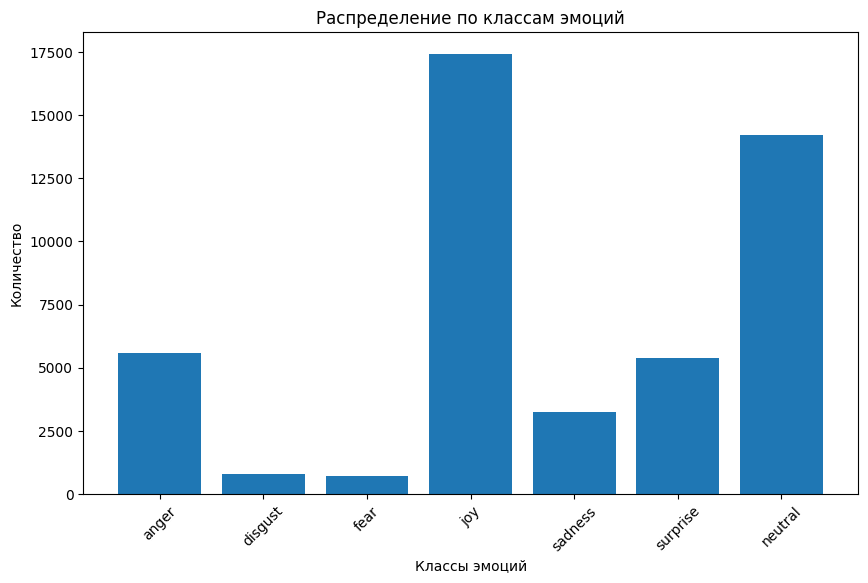

In [ ]:
plot_histogram(data["train"])

In [ ]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

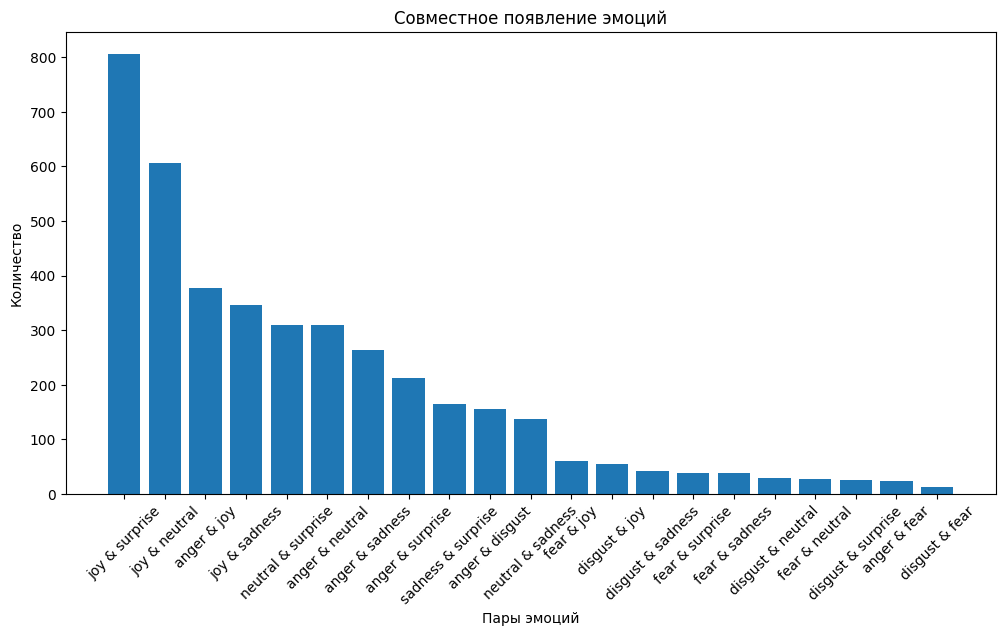

In [ ]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [ ]:
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

In [ ]:
data = data.map(cleaner)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [ ]:
data["train"][3]

{'text': 'чтобы она почувствовала угрозу',
 'anger': 0,
 'disgust': 0,
 'fear': 1,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0}

#### 🏋️ Подготовим модель

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(pretrained_model="ai-forever/ruBert-base", hidden_dim=768, num_classes=len(labels))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

#### 📒 Подготовим данные для обучения

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
max_len = 64

data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [ ]:
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions

    return example

data = data.map(one_hot_to_list)
data["train"][9]["one_hot_labels"]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

[0, 0, 0, 0, 0, 0, 1]

#### 🔗 Dataset & DataLoader

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(self.dataset[index]["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

In [ ]:
train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

#### 🚀 Инициализируем функцию ошибки и оптимизатор

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001, weight_decay=0.)

#### 🥷 Код для обучения и валидации

In [ ]:
def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

    return model

In [ ]:
def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

#### 🏃‍♂️‍➡️ Запускаем обучение

In [ ]:
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    model = train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

Epoch: 0
Train loss: 0.29415846114569455
Valid loss: 0.24148684266735526
Epoch: 1
Train loss: 0.2295751637053595
Valid loss: 0.23565073977498446
Epoch: 2
Train loss: 0.20650933028935334
Valid loss: 0.2368801122202593


In [ ]:
outputs, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs) >= 0.5
print(metrics.classification_report(targets, outputs, target_names=labels))

Valid loss: 0.2368801122202593
              precision    recall  f1-score   support

       anger       0.59      0.45      0.51       717
     disgust       0.56      0.20      0.29        97
        fear       0.55      0.55      0.55       105
         joy       0.81      0.81      0.81      2219
     sadness       0.58      0.54      0.56       390
    surprise       0.56      0.47      0.51       624
     neutral       0.72      0.50      0.59      1766

   micro avg       0.72      0.60      0.66      5918
   macro avg       0.62      0.50      0.55      5918
weighted avg       0.71      0.60      0.65      5918
 samples avg       0.65      0.62      0.63      5918



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ✏️ Получаем результаты на тесте

In [ ]:
test = load_dataset("csv", data_files={"test": "/content/test_without_answers.csv"})

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
test = test.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test = test.map(one_hot_to_list)

Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

In [ ]:
test_dataset = EmotionDataset(test["test"])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
outputs, _ = validation(model, criterion, test_dataloader)
outputs = np.array(outputs) >= 0.5

Valid loss: 0.2963138535981851


#### 🧑‍🍳 Готовим сабмит

In [ ]:
import pandas as pd

df = pd.read_csv("/content/test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [ ]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,0,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,0,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,0,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,0


In [ ]:
df[labels] = outputs.astype(int)

In [ ]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,1,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,1,0,0,0
2,ты реально пустое место,1,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,1,1,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,1


In [ ]:
df.to_csv("/content/submission.csv", index=False)